In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sunspots/Sunspots.csv


In [55]:
import tensorflow as tf #using tensorflow 2.6.0
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [24]:
df_sunspot = pd.read_csv('../input/sunspots/Sunspots.csv')
df_sunspot

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
...,...,...,...
3260,3260,2020-09-30,0.6
3261,3261,2020-10-31,14.4
3262,3262,2020-11-30,34.0
3263,3263,2020-12-31,21.8


In [25]:
print('The shape of the dataset is {}.'.format(df_sunspot.shape))
print('_________________________')
print(df_sunspot.info())

#It has no missing value, the sunspot activities are being recorded each month, since 1749. 

The shape of the dataset is (3265, 3).
_________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3265 non-null   int64  
 1   Date                               3265 non-null   object 
 2   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.6+ KB
None


# Plotting the time series

In [26]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [27]:
time_steps = df_sunspot['Unnamed: 0'].values
series =  df_sunspot['Monthly Mean Total Sunspot Number'].values 
#instead of using the exact date to represent the time series, using time steps to represent each timestamp

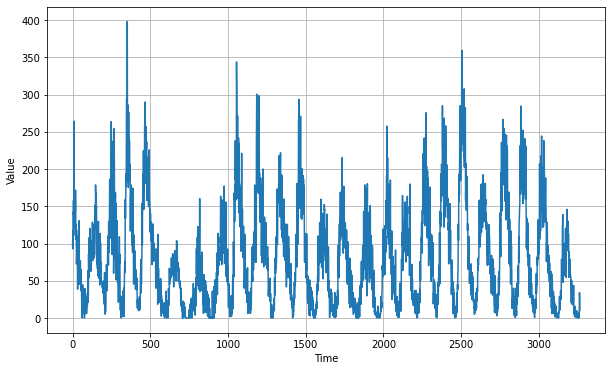

In [28]:
plt.figure(figsize=(10, 6))
plot_series(time_steps, series)

# Data preprocessing for model training

In [43]:
#splitting the dataset to trian, and valid.
#according to the aditional info provided, one cycle of the suspot activities is around 11 years
#each record represents one month, so 11 years has 132 records
#the total number of record is 3265, which can be split into 24 cycle
#taking 22 cycles for train, 2 cycle for validation
#12 x 11 x 22 = 2904

split_time = 2904
time_train = time_steps[:split_time]
x_train = series[:split_time]
time_valid = time_steps[split_time:]
x_valid = series[split_time:]

In [44]:
window_size = 36 #which is equal to 3 years (36 months)
batch_size = 32
shuffle_buffer_size = 1000

In [45]:
#helper function to prepare the dataset for training and forcasting

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [46]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [90]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

#Setting a callbacks function to increase the learning rate gradually during training

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

early_stop = EarlyStopping(monitor='mae',patience=5,min_delta=0.0000001,restore_best_weights=True)


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule,early_stop])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2904,)
Epoch 1/100
90/90 [==============================] - 3s 9ms/step - loss: 142.8604 - mae: 143.3592
Epoch 2/100
90/90 [==============================] - 1s 9ms/step - loss: 124.0600 - mae: 124.5593
Epoch 3/100
90/90 [==============================] - 1s 12ms/step - loss: 108.3584 - mae: 108.8576
Epoch 4/100
90/90 [==============================] - 1s 9ms/step - loss: 96.8954 - mae: 97.3944
Epoch 5/100
90/90 [==============================] - 1s 9ms/step - loss: 86.6542 - mae: 87.1529
Epoch 6/100
90/90 [==============================] - 1s 9ms/step - loss: 76.8079 - mae: 77.3060
Epoch 7/100
90/90 [==============================] - 1s 10ms/step - loss: 68.0965 - mae: 68.5936
Epoch 8/100
90/90 [==============================] - 1s 11ms/step - loss: 61.6012 - mae: 62.0985
Epoch 9/100
90/90 [==============================] - 2s 17ms/step - loss: 57.2378 - mae: 57.7354
Epoch 10/100
90/90 [====

(1e-08, 1e-05, 0.0, 60.0)

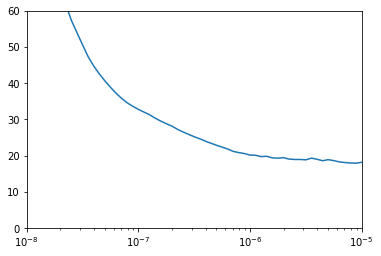

In [91]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-5, 0, 60])

#choosing 1e-6 as the optimal point for learning rate 

MAE = 14.541696


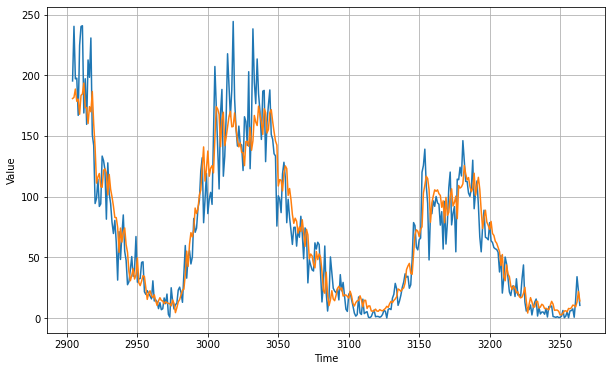

In [92]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

print('MAE =' , tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())
#the MAR looks not bad, it's fitting most of the value, but not capturing some noises

# Plotting Training loss per epochs

<Figure size 432x288 with 0 Axes>

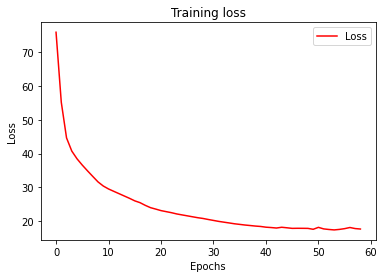

<Figure size 432x288 with 0 Axes>

In [82]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']
epochs=range(len(loss)) # Get number of epochs


plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']
epochs=range(len(loss)) # Get number of epochs

plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)

plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()